0     157866
1     158534
2     159103
3     159892
4     160750
       ...  
88    200926
89    201696
90    202445
91    203274
92    203971
Name: Recovered, Length: 93, dtype: int64
[ 1.40973014  1.46929774  1.52835799  1.58690692  1.64494082  1.70245674
  1.75945244  1.81592607  1.87187643  1.92730268  1.98220401  2.03658052
  2.09043301  2.1437627   2.19657038  2.24885693  2.30062432  2.35187497
  2.4026112   2.45283537  2.5025504   2.55175927  2.60046525  2.64867174
  2.69638236  2.74360084  2.79033109  2.83657714  2.88234314  2.92763345
  2.97245247  3.0168046   3.06069438  3.10412641  3.14710557  3.18963659
  3.23172424  3.27337346  3.31458919  3.35537637  3.39573997  3.43568505
  3.47521661  3.51433969  3.55305938  3.59138075  3.62930884  3.66684875
  3.70400552  3.7407842   3.77718983  3.81322748  3.8489021   3.88421867
  3.91918213  3.95379745  3.98806961  4.02200345  4.05560377  4.0888754
  4.12182311  4.15445174  4.18676595  4.21877039  4.25046968  4.28186841
  4.3129712  

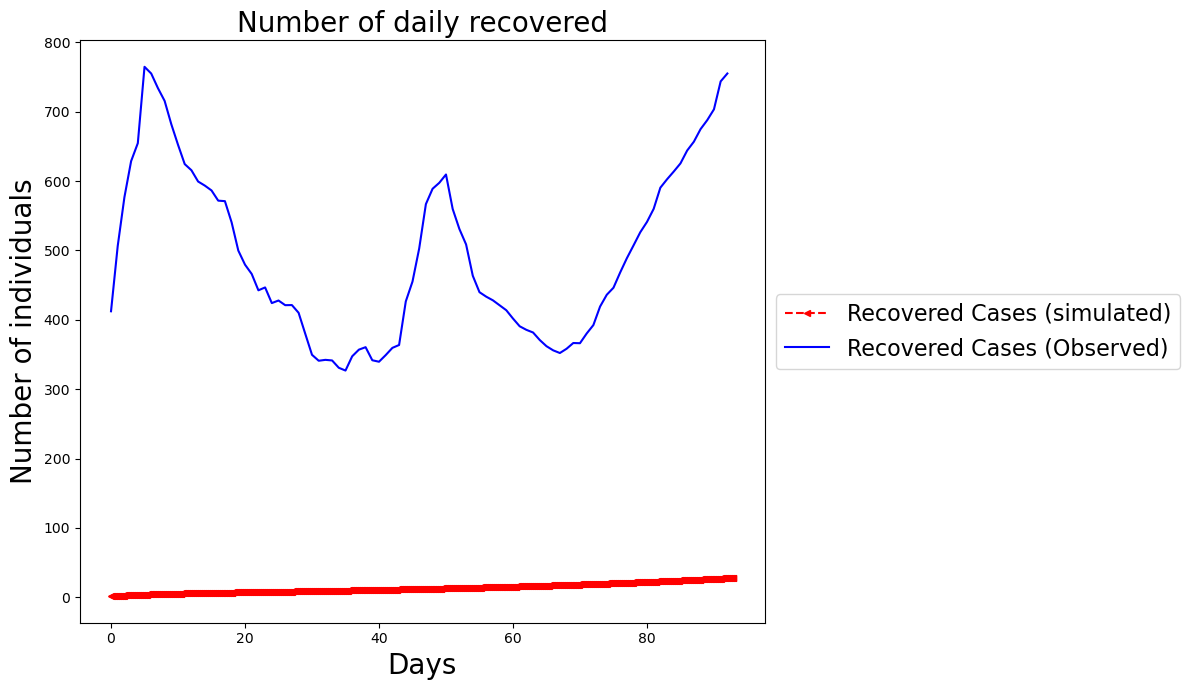

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
from iprocessor import add_day_name_column,smooth_sundays_rolling_w7_l,add_date_name_column
#from numerical_simulation import param_dict_r as param_dict,t_fit

#---------------------------------------------
df = pd.read_csv(r'German_case_period_may_aug.csv')

# -------------------------------------------------------------------------------Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# ------------------------------------------------------------------------------  Modification
# Add the 'days' column
df = add_day_name_column(df)
df = add_date_name_column(df)
print(df['Recovered'])
# ----------------------------------------------------------------------------- second modification with w7_l
df_observed = smooth_sundays_rolling_w7_l(df)

#--------------------------------------------
def derivative_rhs( X,t):
    S, E, A, I, F, R, D = X
    derivS = - contacts * transmission_prob * S * (I + reducing_transmission * A) / total_population
    derivE = contacts * transmission_prob * S * (I + reducing_transmission * A) / total_population - E / exposed_period
    derivA = prob_asymptomatic * E / exposed_period - A / asymptomatic_period
    derivI = (
                         1 - prob_asymptomatic) * E / exposed_period + dev_symp * A / asymptomatic_period - I / infectious_period  # +
    derivF = prob_quarant_inf * I / infectious_period - F / isolated_period + test_asy * A / asymptomatic_period  # prob_isolated_asy*A/asymptomatic_period
    derivR = (1 - prob_quarant_inf - mortality_infected) * I / infectious_period + (
                1 - mortality_isolated) * F / isolated_period + (
                         1 - dev_symp - test_asy) * A / asymptomatic_period  # (1-prob_isolated_asy)*A / asymptomatic_period
    derivD = (mortality_infected) * I / infectious_period + mortality_isolated * F / isolated_period
    return np.array([derivS, derivE, derivA, derivI, derivF, derivR, derivD])



#if __name__ == "__main__":


# 2020.05.20 initialization

total_population = 82_000_000  # Total number of individuals
E0 = 2026.25
A0 = 3798
I0 = 376.4
F0 = 2255
R0 = 170204
D0 = 9060
S0 = total_population - E0 - A0 - I0 - F0 - R0 - D0
initial_conditions = [S0, E0, A0, I0, F0, R0, D0]


'''contacts = param_dict['contacts']
transmission_prob = param_dict['transmission_prob']
reducing_transmission = param_dict['reducing_transmission']
exposed_period = param_dict['exposed_period']
asymptomatic_period = param_dict['asymptomatic_period']
infectious_period = param_dict['infectious_period']
isolated_period = param_dict['isolated_period']
prob_asymptomatic = param_dict['prob_asymptomatic']
prob_quarant_inf = param_dict['prob_quarant_inf']
test_asy = param_dict['test_asy']
dev_symp = param_dict['dev_symp']
mortality_isolated = param_dict['mortality_isolated']
mortality_infected = param_dict['mortality_infected']'''
# ------------------------------------------------------replacing values
contacts = 0.9737  # where we need to estimate the value by fitting
transmission_prob = 0.3154  # 0.3649
total_population = 82000000
reducing_transmission = 0.55  # 0.764
exposed_period = 5.2  #
asymptomatic_period = 7
infectious_period = 3.7
isolated_period = 12  # 11  # 11,23
prob_asymptomatic = 0.34  # 0.2
prob_quarant_inf = 0.9303  # 0.05
test_asy = 0.271  # 0.171
dev_symp = 0.125
mortality_isolated = 0.02
mortality_infected = 0.1

#tmax = t_fit  # maximum simulation day
tmax = 90#269
fslarge = 20
fssmall = 16


t_fit = df_observed['days'].max()
# Plot simulation results
t = np.linspace(0, t_fit, (t_fit +1) * 10)

fig, ax = plt.subplots(figsize=[12, 7])

#  simulated data
solution_seaifrd = integrate.odeint(derivative_rhs, [S0, E0, A0, I0, F0, R0, D0], t)
result_list = np.diff(solution_seaifrd[:, 6])#--------------------------------------applying numpy for the difference
print(result_list)
t = t[:-1]#------------------------reducing last row, as my result_list is one row shorter
print(f't  {t.shape}, result_list {result_list.shape}')
ax.plot(t, result_list, label='Recovered Cases (simulated)', linestyle='--', marker='<', color='red', markersize=4)
#print(f'simulated ,{solution_seaifrd[:, 5]}')
#storing_list = solution_seaifrd[:, 5]
#print(storing_list)

# Overlay the graph of observed confirmed cases
ax.plot(df['n_recovered'],  label='Recovered Cases (Observed)', linestyle='-', color='blue')

# title
ax.set_xlabel('Days', fontsize=fslarge)
ax.set_ylabel('Number of individuals', fontsize=fslarge)
ax.set_title('Number of daily recovered', fontsize=fslarge)

#  legend
ax.legend(fontsize=fssmall, loc='center left', bbox_to_anchor=(1, 0.5))

#  layout
plt.tight_layout()

# Show the plot
plt.show()
